In [1]:
import numpy as np
import pandas as pd
import matplotlib 
import matplotlib.pyplot as plt
import cobra
import pickle
from scipy.integrate import solve_ivp
from finitediff import interpolate_by_finite_diff
import snek

ecoli = cobra.io.read_sbml_model('../models/iML1515_pDNA.xml')
ecoli.solver = 'cplex'

# Experimental Data

In [2]:
df = pd.read_csv("../results/experimental_data.csv",index_col=0)

In [3]:
ctrl = df[df['Information'] == 'lin_ctrl']
slim = df[df['Information'] == 'lin_slim']
m_slim = df[df['Information']=='lin_slim_mean']
m_ctrl = df[df['Information']=='lin_ctrl_mean']

# Figure 5

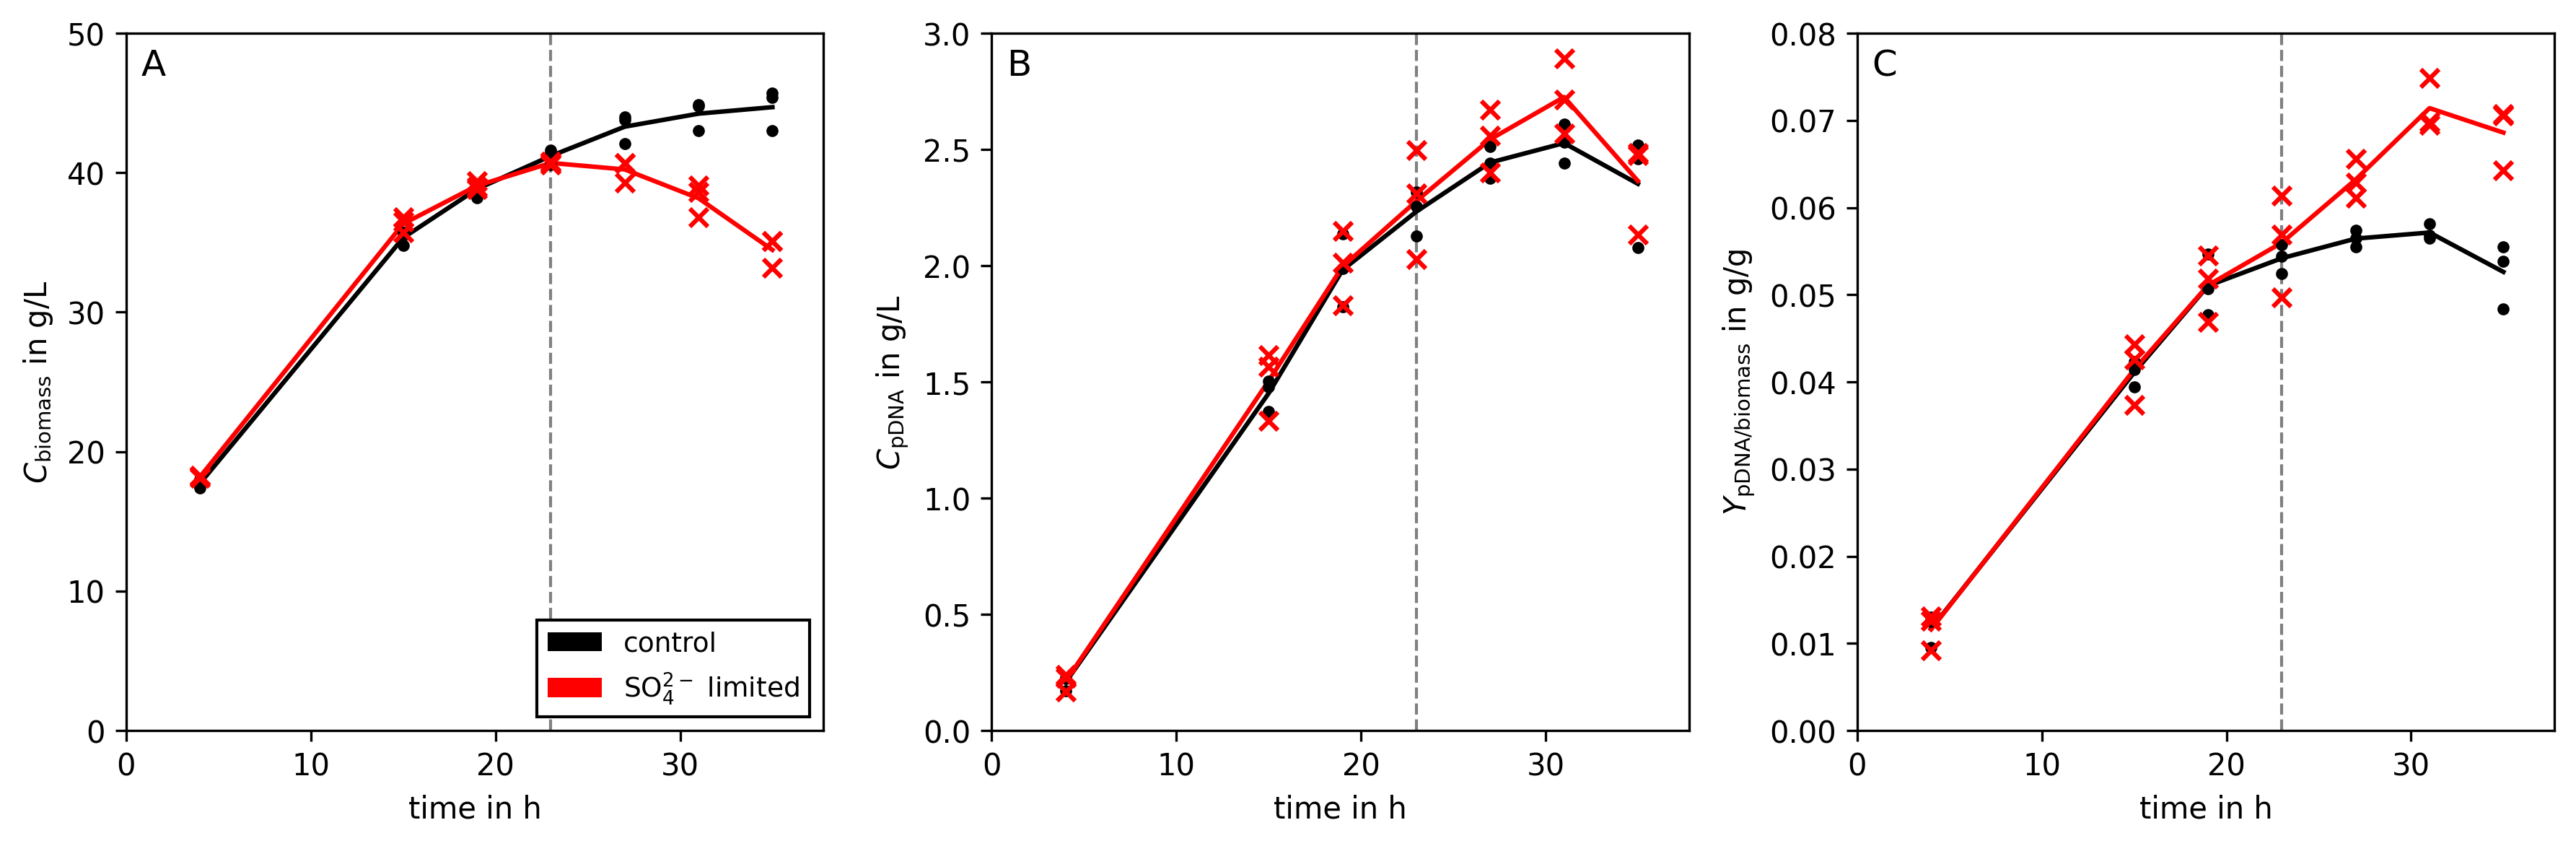

In [4]:
fig = plt.figure(dpi=300,figsize=(12,4))
fig.set_facecolor('w')
ax1 = fig.add_subplot(131,box_aspect=1)
ax2 = fig.add_subplot(132,box_aspect=1)
ax3 = fig.add_subplot(133,box_aspect=1)
for ax in [ax1,ax2,ax3]:
    ax.set_xlabel('time in h')


ax1.bar(0,0,label='control',color='k')
ax1.bar(0,0,label=r'SO$_4^{2-}$ limited',color='r')
ax1.legend(edgecolor='k',fancybox=False,loc='lower right',framealpha=1,fontsize=9)

points = [ctrl,slim]
lines  = [m_ctrl,m_slim]
colors = ['k','r']
marker = ['.','x']

for i in range(2):
    # ax1
    ax1.scatter(points[i]['t[h]'],
                points[i]['X[g]']/points[i]['V[L]'],
                color=colors[i],
                marker=marker[i])
    ax1.plot(lines[i]['t[h]'],
             lines[i]['X[g]']/lines[i]['V[L]'],
             color=colors[i],
             zorder=0)
    # ax2
    ax2.scatter(points[i]['t[h]'],
                points[i]['P[g]']/points[i]['V[L]'],
                color=colors[i],
                marker=marker[i])
    ax2.plot(lines[i]['t[h]'],
             lines[i]['P[g]']/lines[i]['V[L]'],
             color=colors[i],
             zorder=0)
    # ax3
    ax3.scatter(points[i]['t[h]'],
                points[i]['P[g]']/points[i]['X[g]'],
                color=colors[i],
                marker=marker[i])
    ax3.plot(lines[i]['t[h]'],
             lines[i]['P[g]']/lines[i]['X[g]'],
             color=colors[i],
             zorder=0)
    
labels = [r'$C_{\rm biomass}$ in g/L',
          r'$C_{\rm pDNA}$ in g/L',
          r'$Y_{\rm pDNA/biomass}$ in g/g',
         ]

for j,ax in enumerate([ax1,ax2,ax3]):
    ax.set_xlim(0, 37.76)
    ax.set_ylabel(labels[j])
    t_star = 23
    ax.axvline(t_star,zorder=-1,color='grey',linestyle='--',linewidth=1)
ax1.set_ylim(0,50)
ax2.set_ylim(0,3)
ax3.set_ylim(0,.08)

import matplotlib.transforms as mtransforms
for name, ax in zip(['A','B','C','D','E',],[ax1,ax2,ax3]):
    trans = mtransforms.ScaledTranslation(5/72, -5/72, fig.dpi_scale_trans)
    ax.text(0.0, 1.0, name, transform=ax.transAxes + trans,
            fontsize='large', verticalalignment='top', fontfamily='sans',
            bbox=dict(facecolor='none', edgecolor='none', pad=3.0))

fig.align_ylabels()
fig.align_xlabels()
plt.tight_layout()

plt.show()

# Figure 6

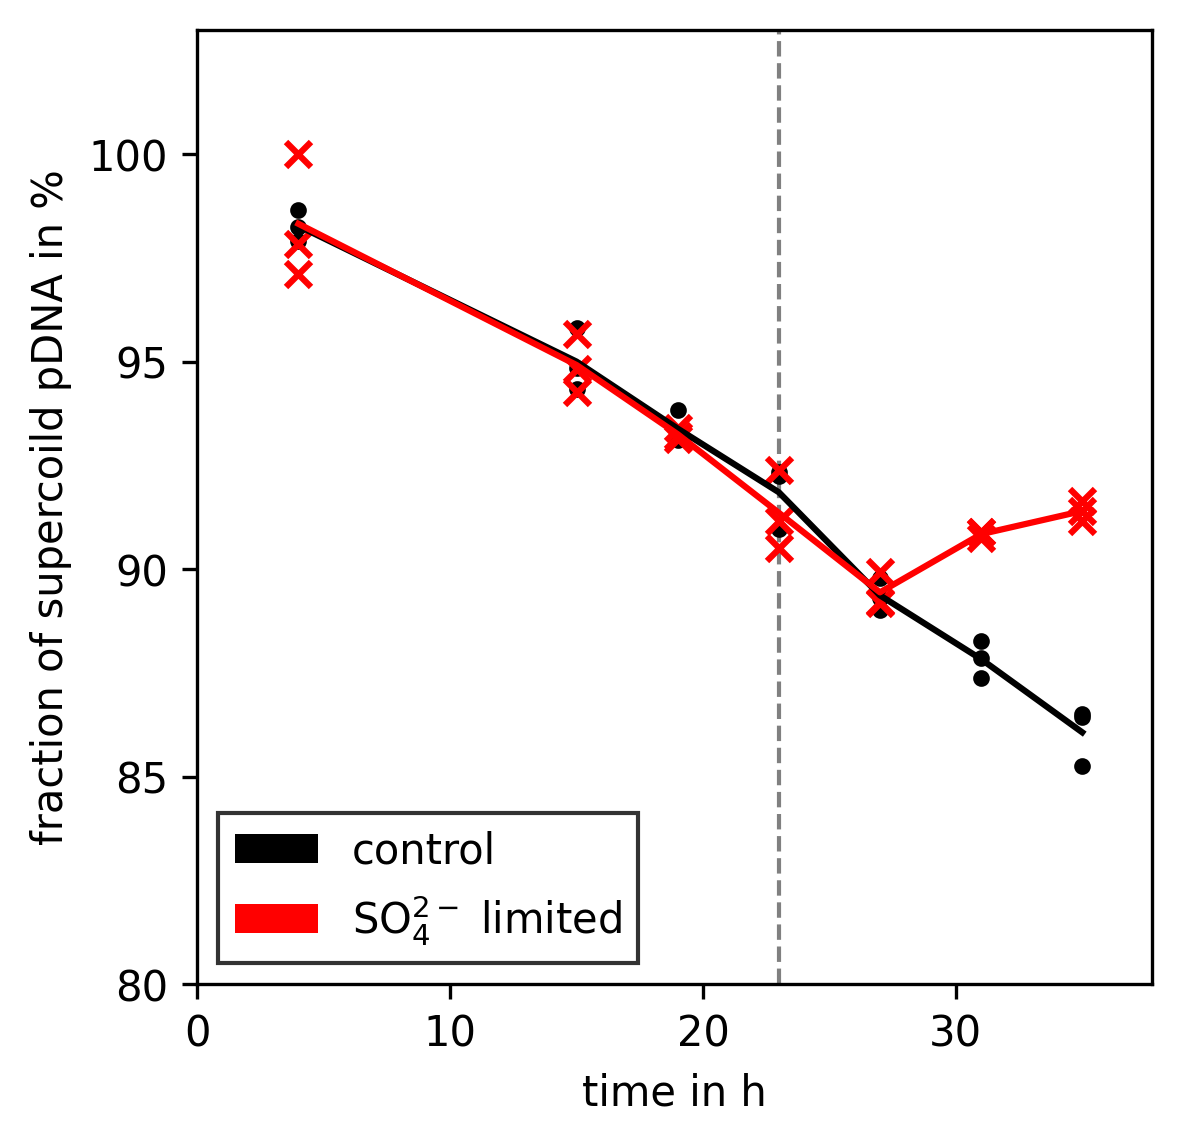

In [5]:
fig = plt.figure(dpi=300,figsize=(4,4))
fig.set_facecolor('w')
ax1 = fig.add_subplot(111,box_aspect=1)

plt.scatter(ctrl['t[h]'],ctrl['ccc[%]'],color='k',marker='.')
plt.plot(m_ctrl['t[h]'],m_ctrl['ccc[%]'],color='k')

plt.scatter(slim['t[h]'],slim['ccc[%]'],color='red',marker='x')
plt.plot(m_slim['t[h]'],m_slim['ccc[%]'],color='red')

ax1.bar(0,0,label='control',color='k')
ax1.bar(0,0,label=r'SO$_4^{2-}$ limited',color='r')

ax1.axvline(23,zorder=-1,color='grey',linestyle='--',linewidth=1)

plt.ylim(80,103)
ax1.set_xlim(0, 37.76)
plt.legend()
plt.xlabel('time in h')
plt.ylabel('fraction of supercoild pDNA in %')

plt.tight_layout()
plt.show()

# Figure 7

In [6]:
with open('../preprocessing/220829_dFBA_lin_feed_v04.pkl','rb') as file:
    lin_processed,lin_special_interest = pickle.load(file)
q_pDNA_max_levels = list(lin_processed.keys())
print(np.array(q_pDNA_max_levels))
q_pDNA_min = .1/100
del file

[0.001  0.0011 0.0012 0.0013 0.0014 0.0015 0.0016 0.0017 0.0018 0.0019
 0.002  0.0021 0.0022 0.0023 0.0024 0.0025 0.0026 0.0027 0.0028 0.0029
 0.003  0.0031 0.0032 0.0033 0.0034 0.0035 0.0036 0.0037 0.0038 0.0039
 0.004  0.0041 0.0042 0.0043 0.0044 0.0045 0.0046 0.0047 0.0048 0.0049
 0.005 ]


In [7]:
def run_pFBA(_in):
    def infeasible_ATPM(t, y, model, tol, r_F_G, r_F_growth):
        '''
        Infeasibility event. Usually occures when the glucose uptake flux is smaller than the ATPM requirement.
        '''

        V,X,S,P,G = y  # expand the boundary species
        q_G = -r_F_G/X
        with model as tmpmodel:
            snek.set_bounds(tmpmodel,'EX_glc__D_e',lb=q_G,ub=q_G)
            if S <= tol:
                snek.set_bounds(tmpmodel,'EX_so4_e',lb=0)
            fluxes = np.array([])
            for reaction, direction in zip(['BIOMASS_Ec_iML1515_core_75p37M'],['max']):
                tmpmodel.objective = reaction
                tmpmodel.objective_direction = direction
                tmp = tmpmodel.slim_optimize()
                if np.isnan(tmp):
                    return 0
                else:
                    return 1
    infeasible_ATPM.terminal = False
    infeasible_ATPM.direction = 0

    def infeasible_V(t, y, model, tol, r_F_G, r_F_growth):
        '''
        Infeasibility event. Usually occures when the volume of the reactor is above 1.
        '''

        V,X,S,P,G = y  # expand the boundary species
        return 1-V
    infeasible_V.terminal = True
    infeasible_V.direction = 0

    def dFBA(t, y, model, tol, r_F_G, r_F_growth):
        """
        Calculate the time derivative of external species.
        """

        V,X,S,P,G = y  # expand the boundary species
        dV_dt = r_F_growth
        q_G = -r_F_G/X
        # Calculate the specific exchanges fluxes at the given external concentrations.
        with model as tmpmodel:
            snek.set_bounds(tmpmodel,'EX_glc__D_e',lb=q_G,ub=q_G)
            if S <= tol:
                snek.set_bounds(tmpmodel,'EX_so4_e',lb=0)
            fluxes = np.array([])
            for reaction, direction in zip(['BIOMASS_Ec_iML1515_core_75p37M','EX_so4_e','pDNA_synthesis','EX_glc__D_e'],['max','max','max','min']):
                tmpmodel.objective = reaction
                tmpmodel.objective_direction = direction
                tmp = tmpmodel.slim_optimize()
                # the nan is excepted here but will trigger the terminal event.
                tmp = np.nan_to_num(tmp)
                fluxes = np.append(fluxes,tmp)
                snek.set_bounds(tmpmodel,reaction,tmp,tmp)
            del tmpmodel

        fluxes *= X
        return np.append(dV_dt,fluxes)
    
    S_0, q_pdna_max, q_pdna_min, ecoli = _in 
    ecoli.solver = 'cplex'
    ecoli.tolerance = 1e-8
    snek.set_bounds(ecoli,'pDNA_synthesis',lb=q_pdna_min,ub=q_pdna_max)
    
    ts = np.linspace(0, 60, 10000)
    # feed rate
    r_F_growth = 13.9/1000 # L/h
    # glucose conc in feed
    G_F = 329.88 # g/L glucose
    # glucse feed rate
    r_F_G = r_F_growth*G_F # gG/h
    r_F_G = r_F_G / snek.elements.molecular_weight('C6H12O6') * 1000 # mmol G/h
    V_0 = .5    # L batch volume
    X_0 = 1.52  # g
    P_0 = 0     # mmol
    y0 = [V_0,X_0,S_0,P_0,0]
    tol = 1e-6
    sol = solve_ivp(
        fun=dFBA,
        t_span=(ts.min(), ts.max()),
        y0=y0,
        t_eval=ts,
        args = (ecoli,tol,r_F_G, r_F_growth),
        events= [infeasible_ATPM,infeasible_V],
        rtol=tol,
        atol=tol,
        method='RK45'
    )
    
    return [S_0, sol]

In [8]:
def calculate_diffs(df,yfactor=1):
    x_fit  = df['t[h]'].values
    nhead = 1
    ntail = 1
    X = df['X[g]'].values
    P = df['P[g]'].values
    t = df['t[h]'].values
    x_data = t
    y_data = P
    interp = interpolate_by_finite_diff(x_data, y_data, x_fit, 1, nhead, ntail)
    dydx_fit = interp[:, 0]/X
    dydx_fit = interp[:, 1]/X
    return x_fit,dydx_fit*yfactor
    
# CALCULATE dP/dt /X
x_fit  = m_ctrl['t[h]'].values
nhead = 1
ntail = 1

# SLIM
tmp = m_slim
X = tmp['X[g]'].values
P = tmp['P[g]'].values
t = tmp['t[h]'].values
x_data = t
y_data = P
interp_slim = interpolate_by_finite_diff(x_data, y_data, x_fit, 1, nhead, ntail)
y_fit_slim = interp_slim[:, 0]/X
dydx_fit_slim = interp_slim[:, 1]/X

tmp = m_ctrl
X = tmp['X[g]'].values
P = tmp['P[g]'].values
t = tmp['t[h]'].values
x_data = t
y_data = P #/X
interp_ctrl = interpolate_by_finite_diff(x_data, y_data, x_fit, 1, nhead, ntail)
y_fit_ctrl = interp_ctrl[:, 0]/X
dydx_fit_ctrl = interp_ctrl[:, 1]/X

/tmp/ipykernel_4131973/2536271754.py:54: RuntimeWarning: invalid value encountered in true_divide
  productivity = P/t
/tmp/ipykernel_4131973/2536271754.py:54: RuntimeWarning: invalid value encountered in true_divide
  productivity = P/t


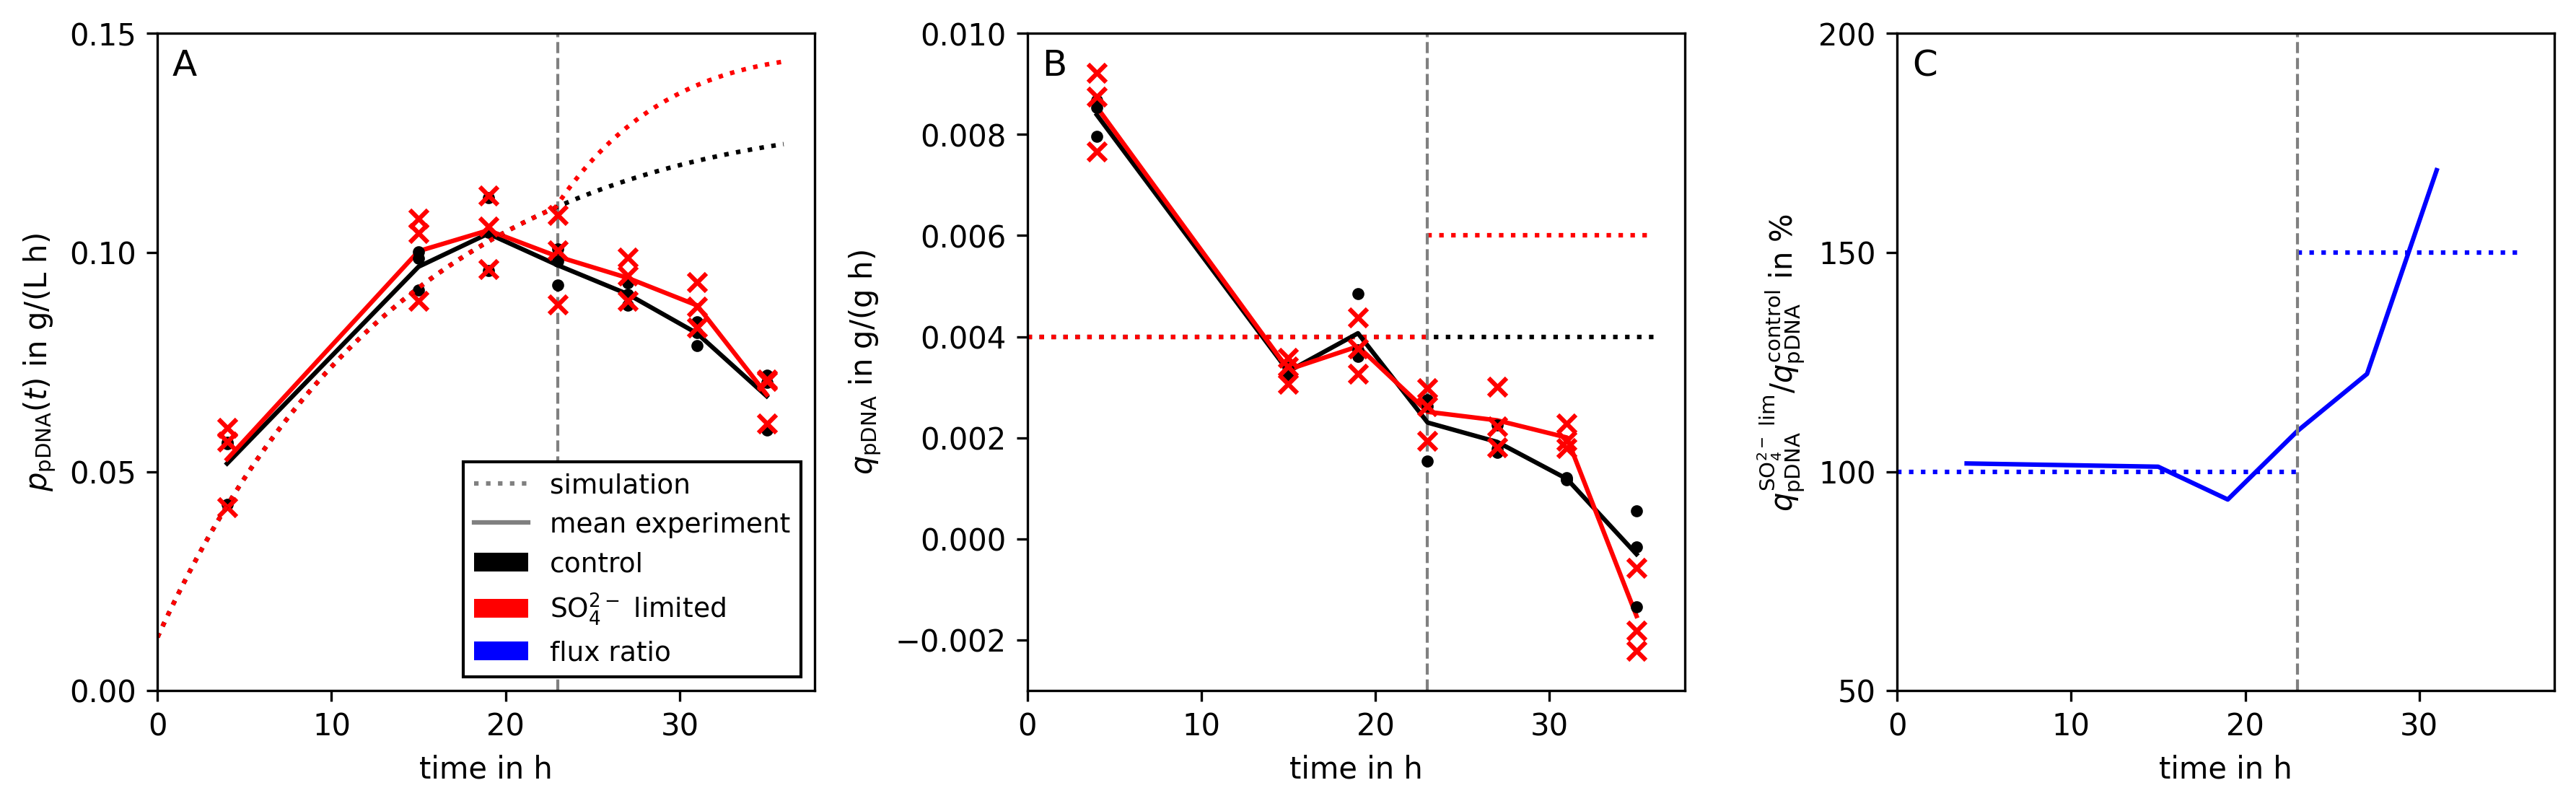

In [9]:
fig = plt.figure(dpi=300,figsize=(12,4))
fig.set_facecolor('w')
ax1 = fig.add_subplot(131,box_aspect=1)
ax3 = fig.add_subplot(132,box_aspect=1)
ax3v2 = fig.add_subplot(133,box_aspect=1)

for ax in [ax3,ax3v2,ax1]:
    ax.set_box_aspect(1)
    ax.set_xlabel('time in h')

ax1.bar(0,0,label='control',color='k')
ax1.bar(0,0,label=r'SO$_4^{2-}$ limited',color='r')
ax1.bar(0,0,label=r'flux ratio',color='b')
ax1.plot(0,0,label='simulation',linestyle=':',color='grey')
ax1.plot(0,0,label='mean experiment',linestyle='-',color='grey')
ax1.legend(edgecolor='k',fancybox=False,loc='lower right',framealpha=1,fontsize=9)

# ax1
q_pDNA_max  = q_pDNA_max_levels[5]
endpoints          = lin_processed[q_pDNA_max]
S_0_array          = endpoints[:,0] # * ecoli.metabolites.so4_e.formula_weight / 1000 / .5    # mmol/L -> g/L
t_end_array        = endpoints[:,1]
V_end_array        = endpoints[:,2]
X_end_array        = endpoints[:,3]
S_end_array        = endpoints[:,4] * ecoli.metabolites.so4_e.formula_weight / 1000    # mmol/L -> g/L
P_end_array        = endpoints[:,5] * ecoli.metabolites.pDNA_c.formula_weight / 1000   # mmol/L -> g/L
G_end_array        = endpoints[:,6] * ecoli.metabolites.glc__D_e.formula_weight / 1000 # mmol/L -> g/L
t_star_start_array = endpoints[:,7]
t_star_len_array   = t_end_array - t_star_start_array
productivity       = P_end_array/t_end_array/V_end_array
idx_ctrl = -1
idx_23h  = np.argmin(np.nan_to_num(np.abs(t_star_len_array-13),nan=1000))
S_0_ctrl = S_0_array[idx_ctrl]
S_0_23h  = S_0_array[idx_23h]

colors = ['k','r']
ratio = {}
for nr, S_0 in enumerate([S_0_ctrl,S_0_23h]):
    q_min = np.mean(dydx_fit_ctrl[:4])/ecoli.metabolites.pDNA_c.formula_weight*1000
    q_min = .004/ecoli.metabolites.pDNA_c.formula_weight*1000
    q_max = 1.5 * q_min 
    S_0 = S_0
    with ecoli as tmp:
        S_0, sol = run_pFBA([S_0,q_max,q_min,tmp])
    del tmp
    
    S_0 = S_0 * ecoli.metabolites.so4_e.formula_weight / 1000    # mmol/L -> g/L
    t   = sol.t                                                    # h
    V   = sol.y.T[:,0]
    X   = sol.y.T[:,1]/V                                                    # g
    S   = sol.y.T[:,2]/V * ecoli.metabolites.so4_e.formula_weight / 1000    # mmol/L -> g/L
    P   = sol.y.T[:,3]/V * ecoli.metabolites.pDNA_c.formula_weight / 1000   # mmol/L -> g/L
    G   = sol.y.T[:,4]/V * ecoli.metabolites.glc__D_e.formula_weight / 1000 # mmol/L -> g/L
    productivity = P/t
    ratio[S_0] = productivity
    ax1.plot(t,productivity,color=colors[nr],linestyle=':')
    
# averages
ax3.plot(x_fit,dydx_fit_ctrl,color='k',zorder=0)
ax3.plot(x_fit,dydx_fit_slim,color='r',zorder=0)

# points
for experiment in ctrl['Experiment'].unique():
    tmp = ctrl[ctrl['Experiment']==experiment]
    ax3.scatter(*calculate_diffs(tmp),color='k',marker='.')
    
for experiment in slim['Experiment'].unique():
    tmp = slim[slim['Experiment']==experiment]
    ax3.scatter(*calculate_diffs(tmp),color='r',marker='x')
    
ylim  = (-.003,.010)
ax3.set_ylim(*ylim)

ax3v2.plot(x_fit[:-1],(dydx_fit_slim/dydx_fit_ctrl*100)[:-1],color='b',zorder=-4)
ax3v2.plot([0,23],[100,100],color='b',linestyle=':',zorder=-5)
ax3v2.plot([23,36],[150,150],color='b',linestyle=':',zorder=-5)
  
for ax in [ax3v2]:
    ax.set_ylim(50,200)
    ax.set_yticks([50,100,150,200])

points = [ctrl,slim]
lines  = [m_ctrl,m_slim]
colors = ['k','r']
marker = ['.','x']
ratio  = {}
for i in range(2):
    # ax1
    ax1.scatter(points[i]['t[h]'],
                points[i]['P[g]']/points[i]['V[L]']/points[i]['t[h]'],
                color=colors[i],
                marker=marker[i])
    ax1.plot(lines[i]['t[h]'],
             lines[i]['P[g]']/lines[i]['V[L]']/lines[i]['t[h]'],
             color=colors[i],
             zorder=0)

ax3.plot([0,23],[.004,.004],color='r',linestyle=':',zorder=-1)
ax3.plot([23,36],[.004*1.5,.004*1.5],color='r',linestyle=':',zorder=-1)
ax3.plot([0,36],[.004]*2,color='k',linestyle=':',zorder=-2)
ax3v2.set_zorder(0)
ax3.set_zorder(1)
ax3.set_facecolor('none')
    
labels = [r'$p_{\rm pDNA}(t)$ in g/(L h)',
          r'$q_{\rm pDNA}$ in g/(g h)',
          r'$q_{\rm pDNA}^{\rm SO_4^{2-}~lim}/q_{\rm pDNA}^{\rm control}$ in %'
         ]

for j,ax in enumerate([ax1,ax3,ax3v2]):
    ax.set_xlim(0, 37.76)
    ax.set_ylabel(labels[j])
    t_star = 23
    ax.axvline(t_star,zorder=-1,color='grey',linestyle='--',linewidth=1)
    
for ax in [ax1]:
    ax.set_yticks([0,.05,.1,.15])
    ax.set_ylim(0,.15)

import matplotlib.transforms as mtransforms
for name, ax in zip(['A','B','C','D','E',],[ax1,ax3,ax3v2]):
    trans = mtransforms.ScaledTranslation(5/72, -5/72, fig.dpi_scale_trans)
    ax.text(0.0, 1.0, name, transform=ax.transAxes + trans,
            fontsize='large', verticalalignment='top', fontfamily='sans',
            bbox=dict(facecolor='none', edgecolor='none', pad=3.0))
    
fig.align_ylabels()
fig.align_xlabels()
plt.tight_layout()
plt.show()

# Values at 31 h

In [10]:
mean_ctrl_M_pdna = np.mean(ctrl.loc[ctrl['t[h]']==31,'P[g]'].values)
mean_ctrl_C_pdna = np.mean(ctrl.loc[ctrl['t[h]']==31,'P[g]'].values/ctrl.loc[ctrl['t[h]']==31,'V[L]'].values)
mean_ctrl_C_bm   = np.mean(ctrl.loc[ctrl['t[h]']==31,'X[g]'].values/ctrl.loc[ctrl['t[h]']==31,'V[L]'].values)
mean_ctrl_p_pdna = np.mean(ctrl.loc[ctrl['t[h]']==31,'P[g]'].values/ctrl.loc[ctrl['t[h]']==31,'V[L]'].values/31)
mean_ctrl_Y_pdna = np.mean(ctrl.loc[ctrl['t[h]']==31,'P[g]'].values/ctrl.loc[ctrl['t[h]']==31,'X[g]'].values)

mean_slim_M_pdna = np.mean(slim.loc[slim['t[h]']==31,'P[g]'].values)
mean_slim_C_pdna = np.mean(slim.loc[slim['t[h]']==31,'P[g]'].values/slim.loc[slim['t[h]']==31,'V[L]'].values)
mean_slim_C_bm   = np.mean(slim.loc[slim['t[h]']==31,'X[g]'].values/slim.loc[slim['t[h]']==31,'V[L]'].values)
mean_slim_p_pdna = np.mean(slim.loc[slim['t[h]']==31,'P[g]'].values/slim.loc[slim['t[h]']==31,'V[L]'].values/31)
mean_slim_Y_pdna = np.mean(slim.loc[slim['t[h]']==31,'P[g]'].values/slim.loc[slim['t[h]']==31,'X[g]'].values)
print('----')
print('AVERAGES')
print('                |  CTRL   |  SLIM   | SLIM/CTRL*100-100')
print('M_pDNA [g]      | {:7.4f} | {:7.4f} | ({:+3.0f}%)'.format(mean_ctrl_M_pdna,mean_slim_M_pdna,(mean_slim_M_pdna/mean_ctrl_M_pdna*100-100)))
print('C_pDNA [g/L]    | {:7.4f} | {:7.4f} | ({:+3.0f}%)'.format(mean_ctrl_C_pdna,mean_slim_C_pdna,(mean_slim_C_pdna/mean_ctrl_C_pdna*100-100)))
print('C_BM   [g/L]    | {:7.4f} | {:7.4f} | ({:+3.0f}%)'.format(mean_ctrl_C_bm  ,mean_slim_C_bm  ,(mean_slim_C_bm  /mean_ctrl_C_bm  *100-100)))
print('p_pDNA [g/(Lh)] | {:7.4f} | {:7.4f} | ({:+3.0f}%)'.format(mean_ctrl_p_pdna,mean_slim_p_pdna,(mean_slim_p_pdna/mean_ctrl_p_pdna*100-100)))
print('Y_pDNA [g/g]    | {:7.4f} | {:7.4f} | ({:+3.0f}%)'.format(mean_ctrl_Y_pdna,mean_slim_Y_pdna,(mean_slim_Y_pdna/mean_ctrl_Y_pdna*100-100)))

std_ctrl_M_pdna = np.std(ctrl.loc[ctrl['t[h]']==31,'P[g]'].values)
std_ctrl_C_pdna = np.std(ctrl.loc[ctrl['t[h]']==31,'P[g]'].values/ctrl.loc[ctrl['t[h]']==31,'V[L]'].values)
std_ctrl_C_bm   = np.std(ctrl.loc[ctrl['t[h]']==31,'X[g]'].values/ctrl.loc[ctrl['t[h]']==31,'V[L]'].values)
std_ctrl_p_pdna = np.std(ctrl.loc[ctrl['t[h]']==31,'P[g]'].values/ctrl.loc[ctrl['t[h]']==31,'V[L]'].values/31)
std_ctrl_Y_pdna = np.std(ctrl.loc[ctrl['t[h]']==31,'P[g]'].values/ctrl.loc[ctrl['t[h]']==31,'X[g]'].values)

std_slim_M_pdna = np.std(slim.loc[slim['t[h]']==31,'P[g]'].values)
std_slim_C_pdna = np.std(slim.loc[slim['t[h]']==31,'P[g]'].values/slim.loc[slim['t[h]']==31,'V[L]'].values)
std_slim_C_bm   = np.std(slim.loc[slim['t[h]']==31,'X[g]'].values/slim.loc[slim['t[h]']==31,'V[L]'].values)
std_slim_p_pdna = np.std(slim.loc[slim['t[h]']==31,'P[g]'].values/slim.loc[slim['t[h]']==31,'V[L]'].values/31)
std_slim_Y_pdna = np.std(slim.loc[slim['t[h]']==31,'P[g]'].values/slim.loc[slim['t[h]']==31,'X[g]'].values)
print('----')
print('STANDARD DEVIATIONS')
print('                |  CTRL   |  SLIM   | SLIM/CTRL*100-100')
print('M_pDNA [g]      | {:7.4f} | {:7.4f} | ({:+3.0f}%)'.format(std_ctrl_M_pdna,std_slim_M_pdna,(mean_slim_M_pdna/mean_ctrl_M_pdna*100-100)))
print('C_pDNA [g/L]    | {:7.4f} | {:7.4f} | ({:+3.0f}%)'.format(std_ctrl_C_pdna,std_slim_C_pdna,(mean_slim_C_pdna/mean_ctrl_C_pdna*100-100)))
print('C_BM   [g/L]    | {:7.4f} | {:7.4f} | ({:+3.0f}%)'.format(std_ctrl_C_bm  ,std_slim_C_bm  ,(mean_slim_C_bm  /mean_ctrl_C_bm  *100-100)))
print('p_pDNA [g/(Lh)] | {:7.4f} | {:7.4f} | ({:+3.0f}%)'.format(std_ctrl_p_pdna,std_slim_p_pdna,(mean_slim_p_pdna/mean_ctrl_p_pdna*100-100)))
print('Y_pDNA [g/g]    | {:7.4f} | {:7.4f} | ({:+3.0f}%)'.format(std_ctrl_Y_pdna,std_slim_Y_pdna,(mean_slim_Y_pdna/mean_ctrl_Y_pdna*100-100)))

----
AVERAGES
                |  CTRL   |  SLIM   | SLIM/CTRL*100-100
M_pDNA [g]      |  2.3456 |  2.5100 | ( +7%)
C_pDNA [g/L]    |  2.5276 |  2.7254 | ( +8%)
C_BM   [g/L]    | 44.2333 | 38.1667 | (-14%)
p_pDNA [g/(Lh)] |  0.0815 |  0.0879 | ( +8%)
Y_pDNA [g/g]    |  0.0571 |  0.0714 | (+25%)
----
STANDARD DEVIATIONS
                |  CTRL   |  SLIM   | SLIM/CTRL*100-100
M_pDNA [g]      |  0.0478 |  0.1211 | ( +7%)
C_pDNA [g/L]    |  0.0683 |  0.1315 | ( +8%)
C_BM   [g/L]    |  0.8731 |  0.9877 | (-14%)
p_pDNA [g/(Lh)] |  0.0022 |  0.0042 | ( +8%)
Y_pDNA [g/g]    |  0.0007 |  0.0025 | (+25%)
